In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

from scipy.special import kl_div
import MDAnalysis as mda
import sys
import itertools
from scipy.special import rel_entr
import matplotlib.pyplot as plt
import glob
import numpy as np
import itertools
import pickle
from scipy.spatial.distance import pdist, cdist

## Making test data

In [3]:
selection = "name CA"
data_dict = {}

for system in glob.glob("../binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/*"):
    name = system.split("/")[-1]
    cosmos = mda.Universe(glob.glob(f"{system}/*gro")[0], glob.glob(f"{system}/*xtc"))
    size = cosmos.select_atoms(selection).positions.flatten()
    pos = np.zeros(size.reshape(1, size.shape[0]).shape)
    for ts in cosmos.trajectory:
        pos = np.concatenate((pos, cosmos.select_atoms(selection).positions.reshape(1, pos.shape[1])))
    pos = pos[~np.all(pos == 0, axis=1)]
    data_dict[name] = pos
    
with open('data_dict.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    

In [27]:
with open('data_dict.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)


dict_keys(['5%-sdpc', 'popc', 'chol-sdpc-site-1', 'chol-sdpc-site-3', 'chol-site-1', 'sdpc', 'chol-site-3', 'chol-sdpc-site-2'])


## FLOW

In [19]:

default_steps = {
    "dim_reducer": {
        PCA(): {
            "n_components": [i for i in range(2, 4)]
        },
    },
    "classifier": {
        GaussianMixture(): {
            "n_components": [i for i in range(2, 5)],
            "covariance_type": ["full", "spherical", "diag", "tied"]
        }
    }
}


In [20]:
def build_pipelines(step_grid):
    
    reducers = step_grid["dim_reducer"]
    classifiers = step_grid["classifier"]
    combinations = list(itertools.product(reducers.keys(), classifiers.keys()))
    pipelines = []
    
    for comb in combinations:
        print(f"fitting combination: {comb}")
        grid = {}
        for param, values in step_grid["dim_reducer"][comb[0]].items():
            key = f"dim_reducer__{param}"
            grid[key] = values
        for param, values in step_grid["classifier"][comb[1]].items():
            key = f"classifier__{param}"
            grid[key] = values
        print(f"with params {grid}")
        pipe = Pipeline(steps=[("dim_reducer", comb[0]), ("classifier", comb[1])])
        cv = GridSearchCV(pipe, param_grid=grid).fit(X)
        pipelines.append(cv.best_estimator_)

    return pipelines



In [21]:

def caluclate_KL(pipeline, X, Y):
    
    preds = pipeline.predict(X)
    cluster_populations = []
    for system in set(Y.flatten()):
        system_preds = preds[np.where(Y == system)[0]]
        populations = [system_preds[np.where(system_preds == i)].shape[0] / system_preds.shape[0] for i in set(preds)]
        cluster_populations.append(populations)
        
    return sum(rel_entr(cluster_populations[0], cluster_populations[1])) # only two systems atm
    


In [22]:

def flow(X, Y, step_grid):
    
    best_KL = 0
    
    pipelines = build_pipelines(step_grid=step_grid)
    best_pipe = pipelines[0]
    for pipe in pipelines:
        KL = caluclate_KL(pipe, X, Y)
        if KL > best_KL:
            best_KL = KL
            best_pipe = pipe
    
    return best_pipe, best_KL    
        


In [28]:
data = np.load("/wrk/eurastof/somethingwithflow/drors_for_all.npy")

systems = [2,7]

X = data[(data[:,4] == systems[0]) | (data[:,4] == systems[1])]
Y = X[:,4]
X = X[:,:-1]



In [29]:
"""X = np.concatenate([data_dict["popc"], data_dict["chol-site-3"]])
Y = np.concatenate([np.ones((data_dict["popc"].shape[0], 1)), 2*np.ones((data_dict["chol-site-3"].shape[0], 1))])"""

pipe, kl = flow(X, Y, default_steps)

print(pipe, kl)

fitting combination: (PCA(), GaussianMixture())
with params {'dim_reducer__n_components': [2, 3], 'classifier__n_components': [2, 3, 4], 'classifier__covariance_type': ['full', 'spherical', 'diag', 'tied']}
Pipeline(steps=[('dim_reducer', PCA(n_components=2)),
                ('classifier', GaussianMixture(n_components=4))]) 2.4243111053336994


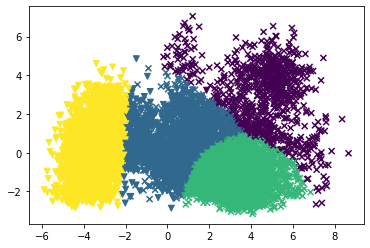

In [38]:
preds = pipe.fit_predict(X)

pca = PCA(n_components=2).fit(X)
transform = pca.transform(X)

sdpc = transform[np.where(Y == systems[0])[0]]
chol = transform[np.where(Y == systems[1])[0]]
sdpc_preds = preds[np.where(Y == systems[0])[0]]
chol_preds = preds[np.where(Y == systems[1])[0]]

plt.scatter(sdpc[:,0], sdpc[:,1], c=sdpc_preds, marker="x", label="sdpc")
plt.scatter(chol[:,0], chol[:,1], c=chol_preds, marker="v", label="chol")



In [44]:
print(pipe["classifier"].means_)



[[ 4.42767858e+00  2.66765435e+00]
 [ 3.93638866e-01  5.02181386e-01]
 [ 3.23683863e+00 -1.16901760e+00]
 [-3.54119550e+00  4.22878424e-03]]


In [47]:
comps = pipe["dim_reducer"].components_
print(comps)

[[ 0.12495585  0.03435602  0.80862235  0.57387768]
 [ 0.24836436  0.96392064 -0.01189097 -0.09503026]]


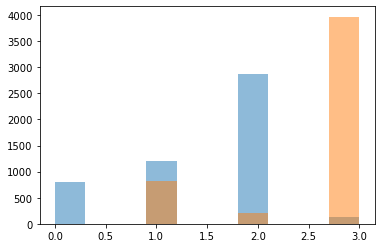

In [39]:
plt.hist(sdpc_preds, alpha=0.5)
plt.hist(chol_preds, alpha=0.5)
plt.show()

feature selection
    
random seeds


